# CSC 3105 Project

# Load and Clean the Data

This code block performs the following operations:

1. Imports necessary libraries for data handling and cleaning.
2. Defines a function `load_data` to load the data from a given directory into a pandas dataframe.
3. Defines a function `clean_data` to clean the loaded data. The cleaning process includes:
   - Handling missing values by dropping them.
   - Removing duplicate rows.
   - Converting the 'NLOS' column to integer data type.
   - Normalizing the 'Measured range (time of flight)' column.
   - Creating new features 'FP_SUM' and 'SNR'.
   - One-hot encoding categorical features.
   - Performing feature extraction on 'CIR' columns.
   - Dropping the original 'CIR' columns.
   - Checking for columns with only one unique value and dropping them.
4. Checks if a pickle file with the cleaned data exists. If it does, it loads the data from the file. If it doesn't, it loads and cleans the data using the defined functions.
5. Prints the first few rows of the cleaned data and its column headers.

In [1]:
import os

import numpy as np
import pandas as pd

DATASET_DIR = './UWB-LOS-NLOS-Data-Set/dataset'


def load_data(dataset_dir):
    # Load the data
    # file_paths = [os.path.join(dirpath, file) for dirpath, _, filenames in os.walk(dataset_dir) for file in filenames if 'uwb_dataset_part7.csv' not in file]
    file_paths = [os.path.join(dirpath, file) for dirpath, _, filenames in os.walk(dataset_dir) for file in filenames]
    data = pd.concat((pd.read_csv(file_path) for file_path in file_paths))
    print(f"Original data shape: {data.shape}")
    return data


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def clean_data(data):
    print("Starting data cleaning process...")

    # Calculate total number of missing values in the data
    total_missing = data.isnull().sum().sum()
    print(f"Total number of missing values: {total_missing}")

    # Statistical Analysis
    print("Statistical Analysis:")
    print(data.describe())

    # Plot Boxplot to check for outliers for the first 15 columns
    print("Boxplot of the first 15 columns:")
    fig, axs = plt.subplots(15,1,dpi=95, figsize=(7,17))
    for i, col in enumerate(data.columns[:15]):
        axs[i].boxplot(data[col], vert=False)
        axs[i].set_ylabel(col)
    plt.show()

    # Data has no missing values
    data = data.dropna()
    print("Missing values dropped.")

    # Data has no duplicate rows
    data = data.drop_duplicates()
    print("Duplicate rows dropped.")

    # Convert 'NLOS' column to integer data type (0 for LOS, 1 for NLOS)
    data['NLOS'] = data['NLOS'].astype(int)
    print("'NLOS' column converted to integer data type.")

    # Create new feature 'FP_SUM' by adding 'FP_AMP1', 'FP_AMP2', and 'FP_AMP3'
    data['FP_SUM'] = data['FP_AMP1'] + data['FP_AMP2'] + data['FP_AMP3']
    print("New feature 'FP_SUM' created.")
    data.drop(['FP_AMP1', 'FP_AMP2', 'FP_AMP3'], axis=1, inplace=True)

    # Calculate SNR as the ratio of 'CIR_PWR' to 'STDEV_NOISE' for each data point
    data['SNR'] = data['CIR_PWR'] / data['STDEV_NOISE']
    print("New feature 'SNR' created.")
    data.drop(['CIR_PWR', 'STDEV_NOISE'], axis=1, inplace=True)

    # One-hot encode categorical features
    categorical_features = ['CH', 'FRAME_LEN', 'PREAM_LEN', 'BITRATE', 'PRFR']
    encoder = LabelEncoder()
    for feature in categorical_features:
        data[feature] = encoder.fit_transform(data[feature])
    print("Categorical features one-hot encoded.")

    # Extract the 'CIR' columns
    cir_columns = [f"CIR{i}" for i in range(1015)]
    # cir_columns = [f"CIR{i}" for i in range(1016)]
    cir_data = data[cir_columns]
    print("'CIR' columns extracted.")

    # Perform PCA on the 'CIR' columns
    pca = PCA(n_components=0.95)
    cir_pca = pca.fit_transform(cir_data)
    print("PCA performed on 'CIR' columns.")

    # Create a DataFrame with the principal components
    cir_pca_df = pd.DataFrame(cir_pca, columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)])
    print("DataFrame with principal components created.")

    # Drop the original 'CIR' columns from the data
    data = data.drop(columns=cir_columns)
    print("Original 'CIR' columns dropped.")

    # Add the principal components to the original data
    # Reset the index of both dataframes
    data = data.reset_index(drop=True)
    cir_pca_df = cir_pca_df.reset_index(drop=True)
    print("Indexes of both dataframes reset.")

    # Concatenate the dataframes
    data = pd.concat([data, cir_pca_df], axis=1)
    print("Dataframes concatenated.")

    # List of columns to check for unique values
    columns_to_check = ['CH', 'PREAM_LEN', 'BITRATE', 'PRFR']

    # Iterate over the columns
    for column in columns_to_check:
        # If the column has only one unique value, drop it
        if data[column].nunique() == 1:
            data = data.drop(column, axis=1)
            print(f"Column '{column}' dropped due to having only one unique value.")

    # Standardize the numerical columns (excluding 'NLOS')
    numerical_cols = data.select_dtypes(include=[np.number]).columns
    numerical_cols = numerical_cols.drop('NLOS')
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
    print("Numerical columns standardized.")

    # Print the shape of the cleaned data
    print(f"Cleaned data shape: {data.shape}")

    print("Data cleaning process completed.")
    # Return the cleaned data
    return data

Pickle file not found. Loading and cleaning data...
Original data shape: (42000, 1031)
Starting data cleaning process...
Total number of missing values: 0
Statistical Analysis:
               NLOS         RANGE        FP_IDX       FP_AMP1       FP_AMP2  \
count  42000.000000  42000.000000  42000.000000  42000.000000  42000.000000   
mean       0.500000      3.831519    745.654167   8127.521905  11425.259524   
std        0.500006      2.355976      4.505024   5393.330697   6235.434769   
min        0.000000      0.000000    707.000000      7.000000     63.000000   
25%        0.000000      1.810000    744.000000   3573.750000   5322.750000   
50%        0.500000      3.480000    746.000000   7140.000000  12318.000000   
75%        1.000000      5.420000    748.000000  12273.000000  17310.000000   
max        1.000000     28.020000    848.000000  20572.000000  20624.000000   

            FP_AMP3   STDEV_NOISE       CIR_PWR     MAX_NOISE       RXPACC  \
count  42000.000000  42000.000000

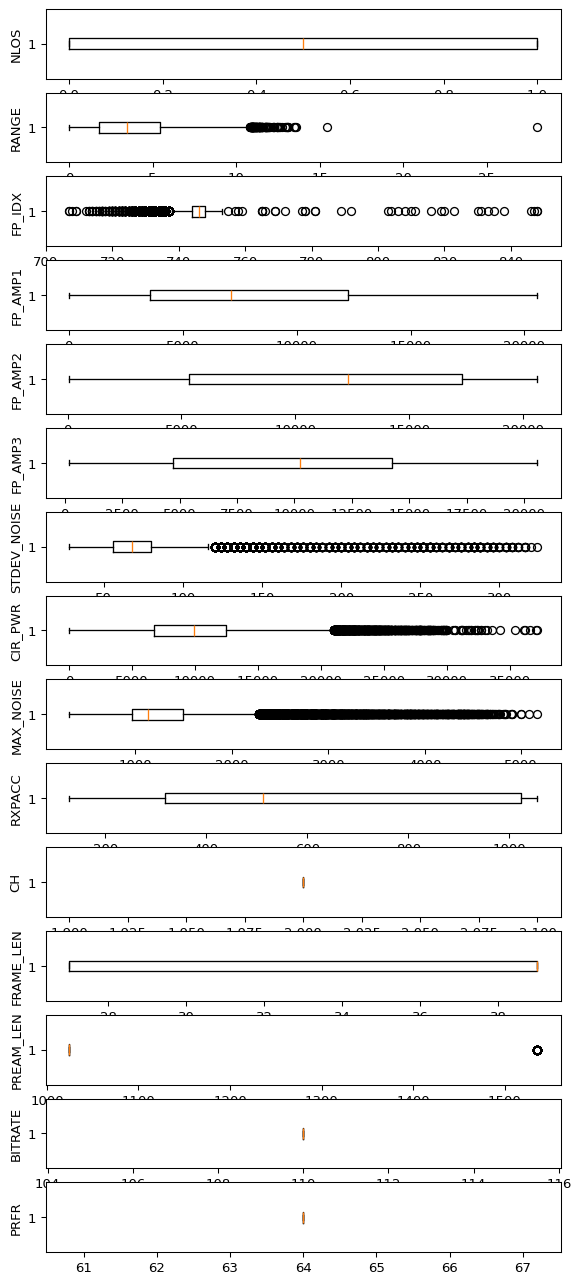

Missing values dropped.
Duplicate rows dropped.
'NLOS' column converted to integer data type.
New feature 'FP_SUM' created.
New feature 'SNR' created.
Categorical features one-hot encoded.
'CIR' columns extracted.
PCA performed on 'CIR' columns.
DataFrame with principal components created.
Original 'CIR' columns dropped.
Indexes of both dataframes reset.
Dataframes concatenated.
Column 'CH' dropped due to having only one unique value.
Column 'BITRATE' dropped due to having only one unique value.
Column 'PRFR' dropped due to having only one unique value.
Numerical columns standardized.
Cleaned data shape: (42000, 49)
Data cleaning process completed.
Data loaded and cleaned successfully.
Saving cleaned data to pickle file...
Cleaned data saved to pickle file successfully.
First few rows of the data:
   NLOS     RANGE    FP_IDX  MAX_NOISE    RXPACC  FRAME_LEN  PREAM_LEN  \
0     0  0.029067 -0.145210  -0.599381 -0.017186   0.874210  -0.196211   
1     0 -1.346176  0.742698  -0.314368 -0.5

In [3]:
import pickle

# File='data_original.pkl'
File = 'data.pkl'

# Check if the file exists
if os.path.exists(File):
    # If the file exists, load it
    print("Loading data from pickle file...")
    with open(File, 'rb') as f:
        data = pickle.load(f)
    print("Data loaded successfully.")
else:
    # If the file doesn't exist, load and clean the data
    print("Pickle file not found. Loading and cleaning data...")
    data = load_data(DATASET_DIR)
    data = clean_data(data)
    print("Data loaded and cleaned successfully.")
    print("Saving cleaned data to pickle file...")
    with open(File, 'wb') as f:
        pickle.dump(data, f)
    print("Cleaned data saved to pickle file successfully.")

print("First few rows of the data:")
print(data.head())

# Print Headers
print("Column headers:")
print(data.columns)

In [4]:
MODEL_DIR = './models'


def train_and_save_model(classifier, X_train, y_train, file_name):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)

    file_path = os.path.join(MODEL_DIR, file_name)

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Training the model and saving it to {file_path}")
        # Train the classifier
        classifier.fit(X_train, y_train)

        # Save the trained model as a pickle string.
        saved_model = pickle.dumps(classifier)

        # Save the pickled model to a file
        with open(file_path, 'wb') as file:
            file.write(saved_model)

    # Load the pickled model from the file
    with open(file_path, 'rb') as file:
        loaded_model = pickle.load(file)

    return loaded_model

The selected code is performing data standardization, which is a common preprocessing step in many machine learning workflows. 

The purpose of standardization is to transform the data such that it has a mean of 0 and a standard deviation of 1. This is done to ensure that all features have the same scale, which is a requirement for many machine learning algorithms.

The mathematical formulas used in this process are as follows:

1. Calculate the mean (μ) of the data:

$$
\mu = \frac{1}{n} \sum_{i=1}^{n} x_i
$$
Where:
- $n$ is the number of observations in the data
- $x_i$ is the value of the $i$-th observation
- $\sum$ denotes the summation over all observations

2. Standardize the data by subtracting the mean from each observation and dividing by the standard deviation:

$$
\text{Data}_i = \frac{x_i - \mu}{\sigma}
$$
Where:
- $\text{Data}_i$ is the standardized value of the $i$-th observation
- $\sigma$ is the standard deviation of the data
- $x_i$ is the value of the $i$-th observation
- $\mu$ is the mean of the data

The `StandardScaler` class from the `sklearn.preprocessing` module is used to perform this standardization. The `fit_transform` method is used to calculate the mean and standard deviation of the data and then perform the standardization.

**Note:** By setting the explained variance to 0.95, we are saying that we want to choose the smallest number of principal components such that 95% of the variance in the original data is retained. This means that the transformed data will retain 95% of the information of the original data, while potentially having fewer dimensions.


## Data Mining / Machine Learning

### I. Supervised Learning
- **Decision**: Supervised learning is used due to the labeled dataset.
- **Algorithm**: Random Forest Classifier is preferred for its performance in classification tasks.

### II. Training/Test Split Ratio
- **Decision**: 70:30 split is chosen for training/test dataset.
- **Reasoning**: This split ensures sufficient data for training and testing.

### III. Performance Metrics
- **Classification Accuracy**: Measures the proportion of correctly classified instances.
- **Confusion Matrix**: Provides a summary of predicted and actual classes.
- **Classification Report**: Provides detailed metrics such as precision, recall, F1-score, and support for each class.

The Random Forest Classifier is trained on the training set and evaluated on the test set using accuracy and classification report metrics.


# Split the data into training and testing sets

The next step is to split the data into training and testing sets. This is a common practice in machine learning, where the training set is used to train the model, and the testing set is used to evaluate its performance.

We will use the `train_test_split` function from the `sklearn.model_selection` module to split the data into training and testing sets. We will use 70% of the data for training and 30% for testing, which is a common split ratio.

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, data['NLOS'], test_size=0.2)

# Load uwb_dataset_part7.csv
# uwb_dataset_part7 = pd.read_csv('./UWB-LOS-NLOS-Data-Set/dataset/uwb_dataset_part7.csv')

# Clean the data
# uwb_dataset_part7 = clean_data(uwb_dataset_part7)

# Split the data into features and labels
# X_test = uwb_dataset_part7
# y_test = uwb_dataset_part7['NLOS']

# print(f"{y_train}")
# print("Y Test")
# print(f"{y_test}")


# Train a Random Forest Classifier

The next step is to train a machine learning model on the training data. We will use the `RandomForestClassifier` class from the `sklearn.ensemble` module to train a random forest classifier.

The random forest classifier is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

We will use the `fit` method of the `RandomForestClassifier` object to train the model on the training data.

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier with parameters to prevent overfitting
classifier = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=5, max_features='sqrt')

loaded_model = train_and_save_model(classifier, X_train, y_train, 'random_forest_classifier.pkl')


# Evaluate the Model

To evaluate the performance of the trained model on the testing data, we will use the `predict` method of the `RandomForestClassifier` object to make predictions on the testing data. We will then use the `accuracy_score` and `classification_report` functions from the `sklearn.metrics` module to calculate the accuracy and generate a classification report.

- **Accuracy:** The accuracy score function calculates the proportion of correctly classified instances.

- **Precision:** The ratio of correctly predicted positive observations to the total predicted positive observations. It is calculated as:

  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  $$

- **Recall:** The ratio of correctly predicted positive observations to all observations in the actual class. It is calculated as:

  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$

- **F1 Score:** The weighted average of precision and recall. It is calculated as:

  $$
  \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

- **Support:** The number of actual occurrences of the class in the dataset.

The classification report provides a summary of the precision, recall, F1-score, and support for each class in the testing data, giving insight into how well the model is performing for each class.


In [7]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

# Make predictions on the test set using the loaded model
y_pred = loaded_model.predict(X_test)

# Evaluate the loaded model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
cross_val_score = cross_val_score(loaded_model, X_test, y_test, cv=5)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")
print(f"Cross Validation Score: {cross_val_score}")


Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4182
           1       1.00      1.00      1.00      4218

    accuracy                           1.00      8400
   macro avg       1.00      1.00      1.00      8400
weighted avg       1.00      1.00      1.00      8400

Cross Validation Score: [1. 1. 1. 1. 1.]


# Visualize a Decision Tree from the Random Forest


In [8]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Select one tree from the forest
estimator = loaded_model.estimators_[0]

plt.figure(figsize=(100, 100))
plot_tree(estimator,
          filled=True,
          rounded=True,
          class_names=['NLOS', 'LOS'],
          feature_names=data.columns,
          max_depth=5)  # Limit the depth of the tree
plt.show()

# Support Vector Machine (SVM)

In [9]:
# import os
# from sklearn.svm import SVC
# import pickle
# 
# svm = SVC(kernel='linear', random_state=42)
# loaded_model = train_and_save_model(svm, X_train, y_train, 'svm_classifier.pkl')
# 
# # Predict the labels for the test set with each model
# y_pred_svm = loaded_model.predict(X_test)
# 
# # Calculate the accuracy of each model
# accuracy_svm = accuracy_score(y_test, y_pred_svm)
# 
# # Print the accuracy of each model
# print(f"Accuracy of SVM: {accuracy_svm}")

# Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Logistic Regression with L2 regularization
log_reg = LogisticRegression(penalty='l2', C=0.1)

# Use the train_and_save_model function to train and save the model
loaded_model = train_and_save_model(log_reg, X_train, y_train, 'logistic_regression_model.pkl')

In [11]:

# Predict on the test set
y_pred_log_reg = loaded_model.predict(X_test)

# Calculate accuracy
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Accuracy of Logistic Regression: {accuracy_log_reg}")

# Perform 5-fold cross validation
scores = cross_val_score(log_reg, X_train, y_train, cv=5)
print(f"Cross-validated scores: {scores}")

Accuracy of Logistic Regression: 1.0
Cross-validated scores: [1. 1. 1. 1. 1.]


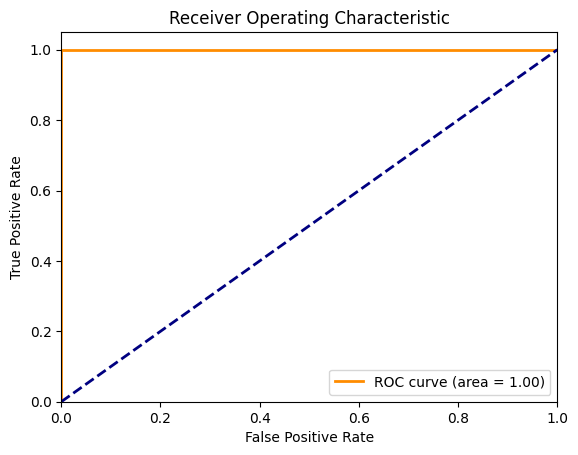

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_log_reg)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Gradient Boosting Classifier

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()

# Use the train_and_save_model function to train and save the model
loaded_model = train_and_save_model(gbc, X_train, y_train, 'gradient_boosting_classifier.pkl')


In [14]:
y_pred_gbc = loaded_model.predict(X_test)
accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
print(f"Accuracy of Gradient Boosting Classifier: {accuracy_gbc}")


Accuracy of Gradient Boosting Classifier: 1.0


# K-Nearest Neighbors (KNN, K=15)

This code block is implementing the K-Nearest Neighbors (KNN) algorithm for classification. The KNN algorithm is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until function evaluation.  

The KNN algorithm works by finding the distances between a query and all the examples in the data, selecting the specified number examples (K) closest to the query, then votes for the most frequent label (in the case of classification) or averages the labels (in the case of regression).  

The number of neighbors, K, is set to 15 in this case. This means that the algorithm looks at the 15 nearest neighbors to decide the class of the test instance.  

The mathematical concept behind KNN is the Euclidean distance. Given two points P1(x1, y1) and P2(x2, y2) in a 2D space, the Euclidean distance between P1 and P2 is calculated as:

$$
\text{Distance} = \sqrt{(x2 - x1)^2 + (y2 - y1)^2}
$$
In higher dimensional space, the formula is generalized as:
$$
\text{Distance} = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}
$$
Where:
- $n$ is the number of dimensions
- $x_i$ and $y_i$ are the $i$-th dimensions of the two points


In [25]:
from sklearn.neighbors import KNeighborsClassifier

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=15)
loaded_model = train_and_save_model(knn, X_train, y_train, 'knn_classifier.pkl')


Training the model and saving it to ./models/knn_classifier.pkl


In [26]:
y_pred_knn = loaded_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy of K-Nearest Neighbors: {accuracy_knn}")

Accuracy of K-Nearest Neighbors: 0.8838095238095238


In [17]:
from sklearn.model_selection import GridSearchCV

# Define the parameter values that should be searched
k_range = list(range(1, 31))

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)

# Instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# Fit the grid with data
grid.fit(X_train, y_train)

# View the complete results
grid.cv_results_

# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.8847023809523809
{'n_neighbors': 15}


Original number of features: 49, reduced number of features: 2


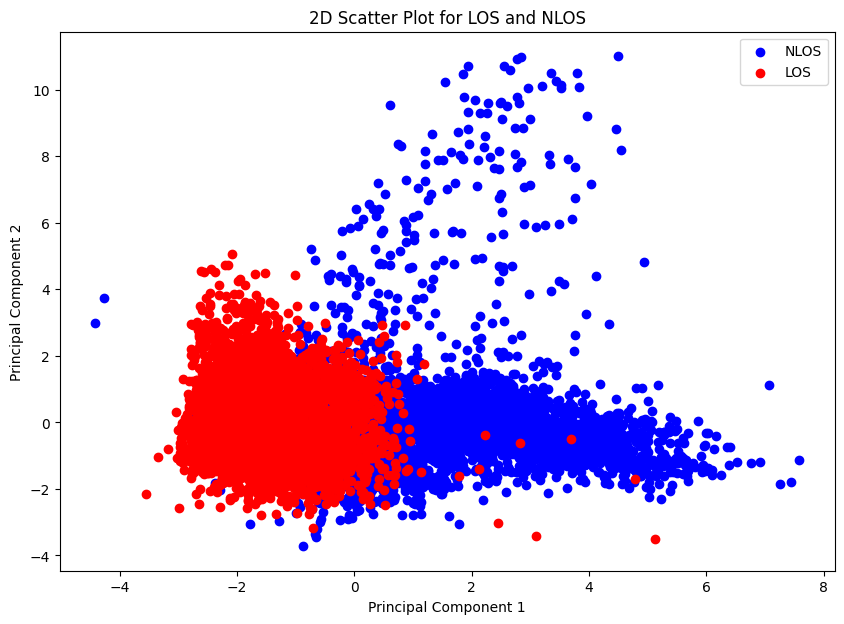

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test)

# Print the number of features
print(f"Original number of features: {X_test.shape[1]}, reduced number of features: {X_test_2d.shape[1]}")

# Create a scatter plot
plt.figure(figsize=(10, 7))

# Create a color map
cmap = plt.cm.viridis

# Plot NLOS points
nlos = plt.scatter(X_test_2d[y_pred_knn == 1, 0], X_test_2d[y_pred_knn == 1, 1], c='blue', label='NLOS')

# Plot LOS points
los = plt.scatter(X_test_2d[y_pred_knn == 0, 0], X_test_2d[y_pred_knn == 0, 1], c='red', label='LOS')

# Add labels
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Scatter Plot for LOS and NLOS')

# Add a legend
plt.legend(handles=[nlos, los])

plt.show()

# Naive Bayes

In [19]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes
nb = GaussianNB()
loaded_model = train_and_save_model(nb, X_train, y_train, 'naive_bayes_classifier.pkl')

In [20]:
y_pred_nb = loaded_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy of Naive Bayes: {accuracy_nb}")

Accuracy of Naive Bayes: 1.0


# K-Means Clustering

In [21]:
from sklearn.cluster import KMeans

# K-Means Clustering
kmeans = KMeans(n_clusters=2, max_iter=600)
loaded_model = train_and_save_model(kmeans, X_train, y_train, 'kmeans_clustering.pkl')

In [22]:
y_pred_kmeans = loaded_model.predict(X_test)
accuracy_kmeans = accuracy_score(y_test, y_pred_kmeans)
print(f"Accuracy of K-Means Clustering: {accuracy_kmeans}")


Accuracy of K-Means Clustering: 0.18797619047619046


In [23]:
labels = loaded_model.labels_
# Print the data table with the cluster labels
print(f"Data table with cluster labels:\n{pd.concat([X_test, pd.DataFrame({'Cluster': labels})], axis=1)}")



Data table with cluster labels:
       NLOS     RANGE    FP_IDX  MAX_NOISE    RXPACC  FRAME_LEN  PREAM_LEN  \
22652   1.0  0.372878  0.520721  -0.719568  0.716234   0.874210  -0.196211   
36477   0.0 -0.717978  0.520721  -0.467176 -0.701712   0.874210  -0.196211   
11620   1.0  0.088491 -0.589164  -0.189030  1.329048   0.874210  -0.196211   
33658   1.0 -0.161939 -1.699049  -0.092881  1.329048  -1.143918  -0.196211   
19021   0.0  0.101225  0.520721  -0.716134 -0.219285   0.874210  -0.196211   
...     ...       ...       ...        ...       ...        ...        ...   
33595   NaN       NaN       NaN        NaN       NaN        NaN        NaN   
33596   NaN       NaN       NaN        NaN       NaN        NaN        NaN   
33597   NaN       NaN       NaN        NaN       NaN        NaN        NaN   
33598   NaN       NaN       NaN        NaN       NaN        NaN        NaN   
33599   NaN       NaN       NaN        NaN       NaN        NaN        NaN   

        CIR1015    FP_SUM      

# Neural Network

In [24]:
# Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dropout

# Define the model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dropout(0.5))  # Dropout layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dropout(0.5))  # Dropout layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

2024-03-09 15:21:28.317893: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-09 15:21:28.320694: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-09 15:21:28.361137: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 15:21:28.361174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 15:21:28.362589: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Epoch 1/100
1050/1050 [==============================] - 2s 2ms/step - loss: 0.3732 - accuracy: 0.8299 - val_loss: 0.0608 - val_accuracy: 0.9850
Epoch 2/100
1050/1050 [==============================] - 1s 1ms/step - loss: 0.0647 - accuracy: 0.9784 - val_loss: 0.0027 - val_accuracy: 0.9995
Epoch 3/100
1050/1050 [==============================] - 1s 1ms/step - loss: 0.0167 - accuracy: 0.9952 - val_loss: 9.9832e-04 - val_accuracy: 0.9999
Epoch 4/100
1050/1050 [==============================] - 1s 1ms/step - loss: 0.0062 - accuracy: 0.9985 - val_loss: 8.3512e-04 - val_accuracy: 0.9999
Epoch 5/100
1050/1050 [==============================] - 1s 1ms/step - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.0012 - val_accuracy: 0.9999
Epoch 6/100
1050/1050 [==============================] - 1s 1ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 5.8861e-04 - val_accuracy: 0.9999
Epoch 7/100
1050/1050 [==============================] - 1s 1ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 1.4